# Import

In [1]:
import random
import os
import os.path as osp
import sys
import math
import copy 
import pprint
import shutil

sys.path.append('./')
from tqdm import tqdm
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import cv2
import copy
import pandas as pd
import seaborn as sns
import imgaug.augmenters as iaa
from PIL import Image
from sklearn import manifold, datasets
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from scipy.special import expit
from scipy.stats import pearsonr

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable

import torchvision
from torchvision import datasets
import torchvision.transforms as T
from torchvision.utils import make_grid
from torchvision.models import resnet152, densenet121, mobilenet_v2

# import SimpleITK as sitk


# from DiffableMaps import ExpModel
from integrated_gradients import IntegratedGradients
from xrai import XRAI
from utils import *
from ExplModel import *
from attack import attack_expl_T, attack_pred_T
# from utils import get_expl, plot_overview, clamp, load_image, make_dir, img_norm
# from chexpert import fetch_dataloader, grad_cam, DenseNet
from dataset import ChexpertSmall

%matplotlib inline

In [2]:
# random seeds
cudnn.benchmark = True
manual_seed = 41
random.seed(manual_seed)
np.random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.cuda.manual_seed(manual_seed)

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select the gpu card number you want to use

# Input the criteria of which XAI you want to evaluate

In [3]:
# criteria_list = ['relevance', 'resistance']
# saliency_method_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']
# criteria = 'relevance'
# saliency_method = 'IntegratedBP'
# assert criteria in criteria_list, "Oopsie, pleasae select the correct criteria for evaluation"
# assert saliency_method in saliency_method_list, "Oopsie, pleasae select the correct saliency method for evaluation"

In [4]:
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'
xai_name = 'VanillaBP' #['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'SmoothBP']

# Settings

In [5]:
cfgs = {}
### model # (densenet121, resnet152, mobilenet_v2, efficientnet-b[0-7])')
# ['VanillaBP', 'VanillaBP_Img', 'GuidedBP', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
    #         'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
# res152_cfgs = {
#     'model_info':{
#         'model_name': 'resnet152',
#         'model_path': '',
#     },
#     'exp_method': 'IntegratedBP',
#     'exp_cfgs':{
# #         'target_layer': ['layer4','2'],
#     }
# }
# mobilV2_cfgs = {
#     'model_info':{
#         'model_name': 'mobilenet_v2',
#         'model_path': '',
#     },
#     'exp_method': 'IntegratedBP',
#     'exp_cfgs':{
# #         'target_layer': ['features', '17'],
#     }
# }

model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
#     mobilV2_cfgs,
#     res152_cfgs,
]
model_cfgs['tgt_models']=[
#     res152_cfgs,
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs


### data
data_cfgs = {}
data_cfgs['data_path'] = ''
data_cfgs['resize'] = 512
data_cfgs['data_mean'] = np.array([0.5330])
data_cfgs['data_std'] = np.array([0.0349])
data_cfgs['mini_data'] = None
data_cfgs['drop_lateral'] = True ## discard images with lateral view
data_cfgs['n_classes'] = len(ChexpertSmall.attr_names)
cfgs['dataset'] = data_cfgs

# att
att_cfgs = {}
att_cfgs['num_iter'] = 1000
att_cfgs['lr'] = 2e-4
att_cfgs['output_dir'] = './save_dir'
att_cfgs['epsilon'] = 0.03
att_cfgs['start_beta'] = None
att_cfgs['end_beta'] = None
att_cfgs['beta_growth'] = False
att_cfgs['prefactors'] = [8e4, 1e1]
cfgs['attack'] = att_cfgs


cfgs['device'] = 'cuda'
cfgs['batch_size'] = 1
### save
cfgs['output_dir'] = ''
# os.makedirs(cfgs['output_dir'], exist_ok=True)

cfgs['restore'] = ''
cfgs['step'] = 0 

# visualize and save expl maps
cfgs['expl_vis'] = True
cfgs['expl_save'] = True
cfgs['expl_save_path'] = ''
# os.makedirs(cfgs['expl_save_path'], exist_ok=True)

In [6]:
obs_dict = {'Atelectasis': 0,
            'Cardiomegaly': 1,
            'Consolidation': 2,
            'Edema': 3,
            'Pleural_Effusion': 4}

# Instantiation models

In [7]:
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]

# __Relevance evaluation__

## VanillaBP

In [8]:
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'
xai_name = 'VanillaBP'
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [9]:
'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

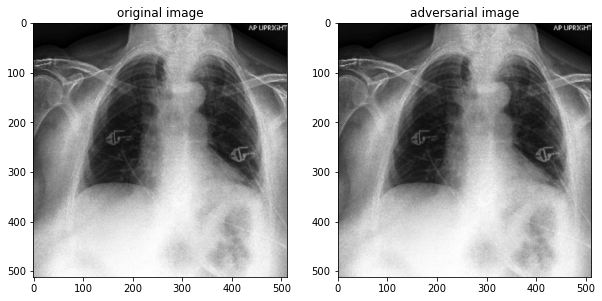

In [10]:
## load original image
plt.figure(figsize=(10,24))

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [11]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

__Compare the predictions__

In [12]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 64.36688899993896 %
adversarial Atelectasis probability: 5.733810737729073 %


__Compare the salienct maps__

In [13]:
heatmap_cln = result_cln[0][0]
heatmap_cln = heatmap_cln.data.cpu().numpy()

heatmap_adv = result_adv[0][0]
heatmap_adv = heatmap_adv.data.cpu().numpy()

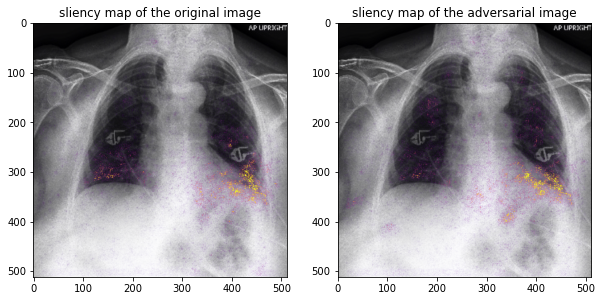

In [14]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()

## VanillaBP * Image

In [15]:
model_name = 'densenet121' #'resnet152'
xai_name = 'VanillaBP_Img'
observatoin_name = 'Atelectasis'
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [16]:
# '''load predictions'''
# xai_name = 'VanillaBP_Img' #['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'SmoothBP']
# save_dir = '' 


# class_index = 0
# img_index = 160
# folder_name = model_name+'_'+xai_name+'_class_'+str(class_index)

# save_img_dir = os.path.join(save_dir, 'save_img')
# os.makedirs(save_img_dir, exist_ok=True)

# pred_org = np.load(os.path.join(save_dir, folder_name, 'org_pred.npy'))
# pred_att = np.load(os.path.join(save_dir, folder_name, 'adv_pred.npy'))
# label = np.load(os.path.join(save_dir, folder_name, 'org_labels.npy'))

# '''load heat map'''
# hm_org = np.load(os.path.join(save_dir, folder_name, 'org_hm.npy'))
# hm_att = np.load(os.path.join(save_dir, folder_name, 'adv_hm.npy'))

# '''load images'''
# img_org = np.load(os.path.join(save_dir, folder_name, 'org_imgs.npy'))
# img_att = np.load(os.path.join(save_dir, folder_name, 'adv_imgs.npy'))

# print(hm_att.shape, img_att.shape)
# print(label[img_index])
'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

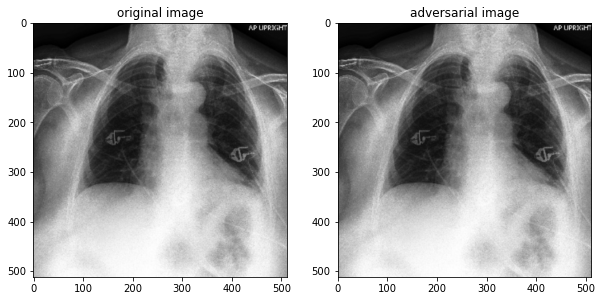

In [17]:
## load original image
plt.figure(figsize=(10,24))
# base_img_cln  = img_org[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_org_imgs_'+xai_name+'.npy'), base_img_cln)

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

# base_img_adv  = img_att[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_adv_imgs_'+xai_name+'.npy'), base_img_adv)

img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [18]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

__Compare the predictions__

In [19]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 64.36688899993896 %
adversarial Atelectasis probability: 10.91684103012085 %


__Compare the salienct maps__

In [20]:
heatmap_cln = result_cln[0][0]
heatmap_cln = heatmap_cln.data.cpu().numpy()

heatmap_adv = result_adv[0][0]
heatmap_adv = heatmap_adv.data.cpu().numpy()

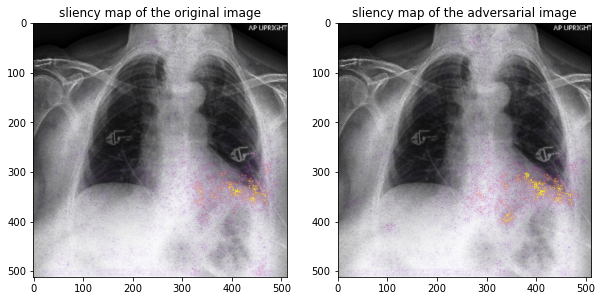

In [21]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()

## GradCAM

In [22]:
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'
xai_name = 'GradCAM'
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [23]:
# '''load predictions'''
# folder_name = model_name+'_'+xai_name+'_class_'+str(class_index)

# save_img_dir = os.path.join(save_dir, 'save_img')
# os.makedirs(save_img_dir, exist_ok=True)

# pred_org = np.load(os.path.join(save_dir, folder_name, 'org_pred.npy'))
# pred_att = np.load(os.path.join(save_dir, folder_name, 'adv_pred.npy'))
# label = np.load(os.path.join(save_dir, folder_name, 'org_labels.npy'))

# '''load heat map'''
# hm_org = np.load(os.path.join(save_dir, folder_name, 'org_hm.npy'))
# hm_att = np.load(os.path.join(save_dir, folder_name, 'adv_hm.npy'))

# '''load images'''
# img_org = np.load(os.path.join(save_dir, folder_name, 'org_imgs.npy'))
# img_att = np.load(os.path.join(save_dir, folder_name, 'adv_imgs.npy'))

# print(hm_att.shape, img_att.shape)
# print(label[img_index])
# class_of_interest = [1., 0., 0., 0., 0.]

'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

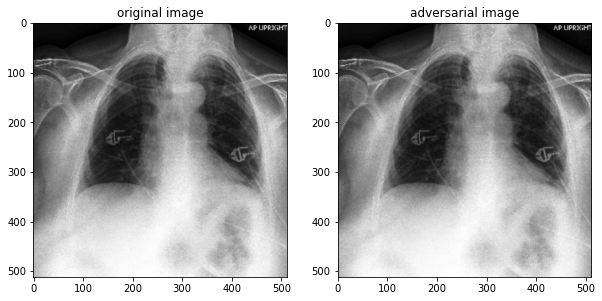

In [24]:
## load original image
plt.figure(figsize=(10,24))
# base_img_cln  = img_org[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_org_imgs_'+xai_name+'.npy'), base_img_cln)

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

# base_img_adv  = img_att[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_adv_imgs_'+xai_name+'.npy'), base_img_adv)
img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [25]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

__Compare the predictions__

In [26]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 64.36688899993896 %
adversarial Atelectasis probability: 1.947001926600933 %


__Compare the salienct maps__

In [27]:
heatmap_cln = result_cln[0][0]
heatmap_cln = heatmap_cln.data.cpu().numpy()

heatmap_adv = result_adv[0][0]
heatmap_adv = heatmap_adv.data.cpu().numpy()

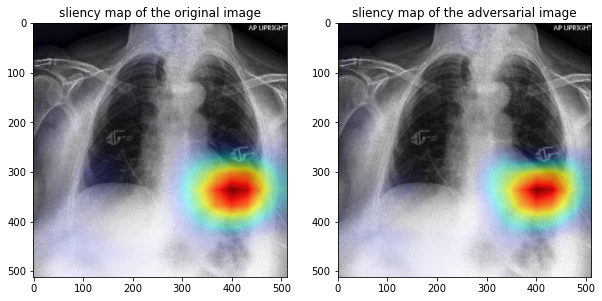

In [28]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=1.0) # norm grad to speial range
cmap = cm.jet_r(1-heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=1.0) # norm grad to speial range
cmap = cm.jet_r(1-heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()

## Guided-GradCAM

In [29]:
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']
xai_name = 'GuidedGradCAM'
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [30]:
# '''load predictions'''
# class_index = 0
# img_index = 160

# folder_name = model_name+'_'+'GradCAM'+'_class_'+str(class_index)

# save_img_dir = os.path.join(save_dir, 'save_img')
# os.makedirs(save_img_dir, exist_ok=True)

# pred_org = np.load(os.path.join(save_dir, folder_name, 'org_pred.npy'))
# pred_att = np.load(os.path.join(save_dir, folder_name, 'adv_pred.npy'))
# label = np.load(os.path.join(save_dir, folder_name, 'org_labels.npy'))

# '''load heat map'''
# hm_org = np.load(os.path.join(save_dir, folder_name, 'org_hm.npy'))
# hm_att = np.load(os.path.join(save_dir, folder_name, 'adv_hm.npy'))

# '''load images'''
# img_org = np.load(os.path.join(save_dir, folder_name, 'org_imgs.npy'))
# img_att = np.load(os.path.join(save_dir, folder_name, 'adv_imgs.npy'))

# print(hm_att.shape, img_att.shape)
# print(label[img_index])
# class_of_interest = [1., 0., 0., 0., 0.]

'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

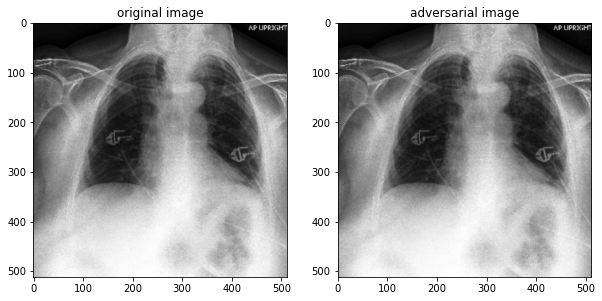

In [31]:
## load original image
plt.figure(figsize=(10,24))
# base_img_cln  = img_org[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_org_imgs_'+xai_name+'.npy'), base_img_cln)

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

# base_img_adv  = img_att[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_adv_imgs_'+xai_name+'.npy'), base_img_adv)

img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [32]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

/home/zhangj41/anaconda3/lib/python3.8/site-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


gradcam:  torch.Size([1, 512, 512])
hm_guidedbp:  3
product:  3
gradcam:  torch.Size([1, 512, 512])
hm_guidedbp:  3
product:  3


__Compare the predictions__

In [33]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 64.36688899993896 %
adversarial Atelectasis probability: 1.947001926600933 %


__Compare the salienct maps__

In [34]:
heatmap_cln = result_cln[0][0]
heatmap_cln = heatmap_cln.data.cpu().numpy()

heatmap_adv = result_adv[0][0]
heatmap_adv = heatmap_adv.data.cpu().numpy()

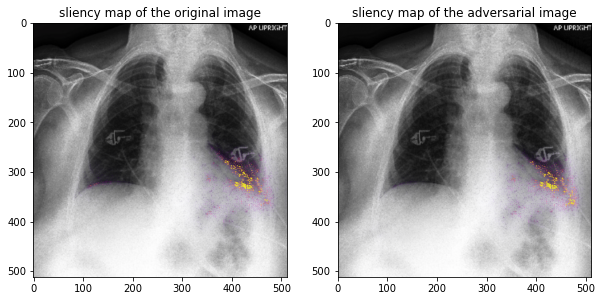

In [35]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=5.7) # norm grad to speial range
cmap = cm.plasma(heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=5.7) # norm grad to speial range
cmap = cm.plasma(heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()

## Integrated Grad (IG)

In [36]:
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']
xai_name = 'IntegratedBP'
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [37]:
# '''load predictions'''
# folder_name = model_name+'_'+xai_name+'_class_'+str(class_index)

# save_img_dir = os.path.join(save_dir, 'save_img')
# os.makedirs(save_img_dir, exist_ok=True)

# pred_org = np.load(os.path.join(save_dir, folder_name, 'org_pred.npy'))
# pred_att = np.load(os.path.join(save_dir, folder_name, 'adv_pred.npy'))
# label = np.load(os.path.join(save_dir, folder_name, 'org_labels.npy'))

# '''load heat map'''
# hm_org = np.load(os.path.join(save_dir, folder_name, 'org_hm.npy'))
# hm_att = np.load(os.path.join(save_dir, folder_name, 'adv_hm.npy'))

# '''load images'''
# img_org = np.load(os.path.join(save_dir, folder_name, 'org_imgs.npy'))
# img_att = np.load(os.path.join(save_dir, folder_name, 'adv_imgs.npy'))

# print(hm_att.shape, img_att.shape)
# print(label[img_index])
# class_of_interest = [1., 0., 0., 0., 0.]


'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

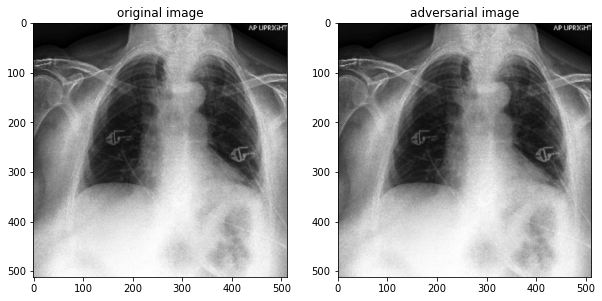

In [38]:
## load original image
plt.figure(figsize=(10,24))
# base_img_cln  = img_org[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_org_imgs_'+xai_name+'.npy'), base_img_cln)

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

# base_img_adv  = img_att[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_adv_imgs_'+xai_name+'.npy'), base_img_adv)

img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [39]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

__Compare the salienct maps__

In [40]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 64.36688899993896 %
adversarial Atelectasis probability: 5.733810737729073 %


__Compare the salienct maps__

In [41]:
heatmap_cln = result_cln[0][0]
heatmap_cln = heatmap_cln.data.cpu().numpy()

heatmap_adv = result_adv[0][0]
heatmap_adv = heatmap_adv.data.cpu().numpy()

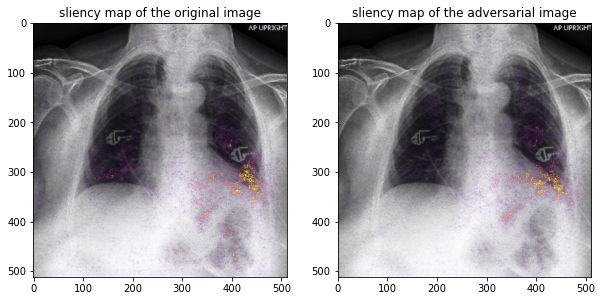

In [42]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()

## Smooth Grad (SG)

In [43]:
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']
xai_name = 'SmoothBP'
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [44]:
# '''load predictions'''
# class_index = 0
# img_index = 160
# folder_name = model_name+'_'+xai_name+'_class_'+str(class_index)
# save_img_dir = os.path.join(save_dir, 'save_img')
# os.makedirs(save_img_dir, exist_ok=True)

# pred_org = np.load(os.path.join(save_dir, folder_name, 'org_pred.npy'))
# pred_att = np.load(os.path.join(save_dir, folder_name, 'adv_pred.npy'))
# label = np.load(os.path.join(save_dir, folder_name, 'org_labels.npy'))

# '''load heat map'''
# hm_org = np.load(os.path.join(save_dir, folder_name, 'org_hm.npy'))
# hm_att = np.load(os.path.join(save_dir, folder_name, 'adv_hm.npy'))

# '''load images'''
# img_org = np.load(os.path.join(save_dir, folder_name, 'org_imgs.npy'))
# img_att = np.load(os.path.join(save_dir, folder_name, 'adv_imgs.npy'))

# print(hm_att.shape, img_att.shape)
# print(label[img_index])
# class_of_interest = [1., 0., 0., 0., 0.]


'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

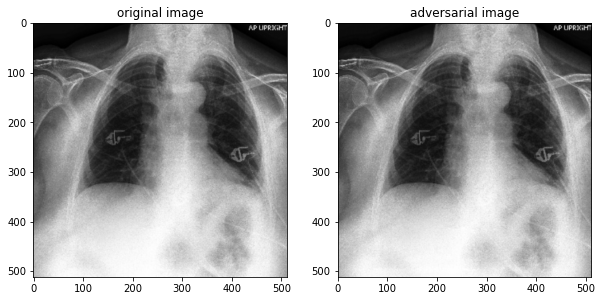

In [45]:
## load original image
plt.figure(figsize=(10,24))
# base_img_cln  = img_org[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_org_imgs_'+xai_name+'.npy'), base_img_cln)

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

# base_img_adv  = img_att[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_adv_imgs_'+xai_name+'.npy'), base_img_adv)

img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [46]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

__Compare the salienct maps__

In [47]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 57.09027051925659 %
adversarial Atelectasis probability: 2.224561385810375 %


__Compare the salienct maps__

In [48]:
heatmap_cln = result_cln[0][0]
heatmap_cln = heatmap_cln.data.cpu().numpy()

heatmap_adv = result_adv[0][0]
heatmap_adv = heatmap_adv.data.cpu().numpy()

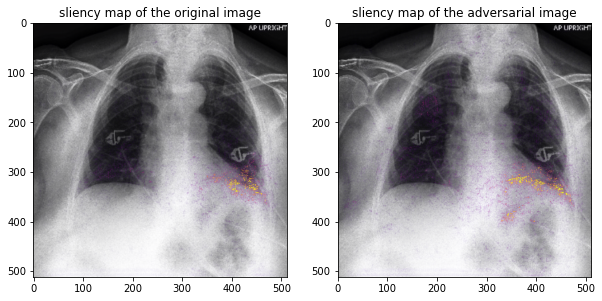

In [49]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=3.0) # norm grad to speial range
cmap = cm.plasma(heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
    
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight

plt.imshow(img_fused[0])
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()

## XRAI

In [50]:
xai_name_list = ['VanillaBP', 'VanillaBP_Img', 'IntegratedBP', 'GradCAM', 'GuidedGradCAM', 'SmoothBP', 'XRAI']
xai_name = 'XRAI'
model_name = 'densenet121' #'resnet152'
observatoin_name = 'Atelectasis'

assert xai_name in xai_name_list, "Oopsie, pleasae select the correct saliency method for evaluation"
if xai_name in ['GradCAM', 'GuidedGradCAM']:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
            'target_layer': ['features','denseblock4','denselayer14'],
        }
    }
else:
    dense121_cfgs = {
        'model_info':{
            'model_name': 'densenet121',
            'model_path': './Model_sample/DenseNet121.pt',
        },
        'exp_method': xai_name,
        'exp_cfgs':{
        }
    }


model_cfgs = {}
model_cfgs['src_models']=[
    dense121_cfgs,
]
model_cfgs['tgt_models']=[
]
model_cfgs['pretrained'] = False
cfgs['model'] = model_cfgs

### load radiograph samples

In [51]:
# '''load predictions'''
# class_index = 0
# img_index = 160
# folder_name = model_name+'_'+'IntegratedBP'+'_class_'+str(class_index)
# save_img_dir = os.path.join(save_dir, 'save_img')
# os.makedirs(save_img_dir, exist_ok=True)

# pred_org = np.load(os.path.join(save_dir, folder_name, 'org_pred.npy'))
# pred_att = np.load(os.path.join(save_dir, folder_name, 'adv_pred.npy'))
# label = np.load(os.path.join(save_dir, folder_name, 'org_labels.npy'))

# '''load heat map'''
# hm_org = np.load(os.path.join(save_dir, folder_name, 'org_hm.npy'))
# hm_att = np.load(os.path.join(save_dir, folder_name, 'adv_hm.npy'))

# '''load images'''
# img_org = np.load(os.path.join(save_dir, folder_name, 'org_imgs.npy'))
# img_att = np.load(os.path.join(save_dir, folder_name, 'adv_imgs.npy'))

# print(hm_att.shape, img_att.shape)
# print(label[img_index])
# class_of_interest = [1., 0., 0., 0., 0.]


'''load image pairs'''
base_img_cln = np.load(os.path.join('./Image_sample/relevance_org_imgs_'+xai_name+'.npy'))
base_img_adv = np.load(os.path.join('./Image_sample/relevance_adv_imgs_'+xai_name+'.npy'))

'''set class of interest'''
class_of_interest = [1., 0., 0., 0., 0.]

### visualize the original image and the adversarial image

Text(0.5, 1.0, 'adversarial image')

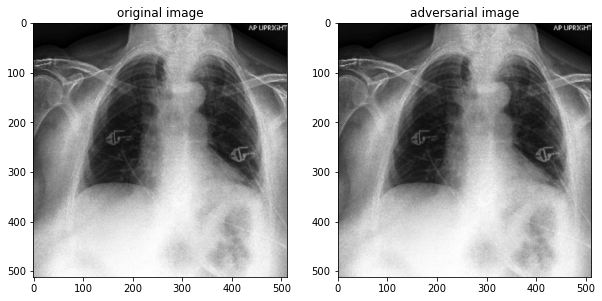

In [52]:
## load original image
plt.figure(figsize=(10,24))
# base_img_cln  = img_org[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_org_imgs_'+xai_name+'.npy'), base_img_cln)

img_cln = np.zeros((base_img_cln.shape[0], base_img_cln.shape[1], 3))
img_cln[:,:,0], img_cln[:,:,1], img_cln[:,:,2] = base_img_cln, base_img_cln, base_img_cln

# base_img_adv  = img_att[img_index, 0, :, :]
# save_dir = './Image_sample'
# np.save(os.path.join(save_dir, 'relevance_adv_imgs_'+xai_name+'.npy'), base_img_adv)

img_adv = np.zeros((base_img_adv.shape[0], base_img_adv.shape[1], 3))
img_adv[:,:,0], img_adv[:,:,1], img_adv[:,:,2] = base_img_adv, base_img_adv, base_img_adv

plt.subplot(1,2,1)
plt.imshow(img_cln)
plt.title('original image')
plt.subplot(1,2,2)
plt.imshow(img_adv)
plt.title('adversarial image')

### compute and compare the model predictions and salieny maps

In [53]:
base_img_cln, base_img_adv = torch.Tensor(base_img_cln), torch.Tensor(base_img_adv)
base_img_cln = base_img_cln.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)
base_img_adv = base_img_adv.to(torch.device(cfgs['device'])).unsqueeze(0).unsqueeze(0)

source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_cln = [_.cal_exp_map(base_img_cln, class_of_interest) for _ in source_exp_models]
source_exp_models = [expmodel_factory(model_cfgs, cfgs) for model_cfgs in cfgs['model']['src_models']]
result_adv = [_.cal_exp_map(base_img_adv, class_of_interest) for _ in source_exp_models]

ii
(512, 512, 1)
ii
(512, 512, 1)


__Compare the salienct maps__

In [54]:
prediction_cln = torch.sigmoid(result_cln[0][1])
prediction_adv = torch.sigmoid(result_adv[0][1])
'''the first logit of the model output is corresponding to the observation of Atelectasis'''
print('Original Atelectasis probability: {} %'.format(prediction_cln[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )
print('adversarial Atelectasis probability: {} %'.format(prediction_adv[0][obs_dict['Atelectasis']].data.cpu().numpy()*100) )

Original Atelectasis probability: 64.36688899993896 %
adversarial Atelectasis probability: 5.733810737729073 %


__Compare the salienct maps__

In [55]:
heatmap_cln = result_cln[0][0]
heatmap_adv = result_adv[0][0]

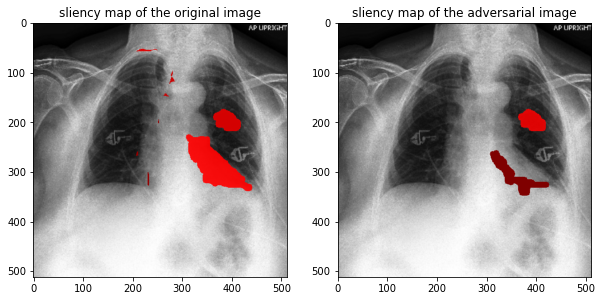

In [56]:
## load original image
plt.figure(figsize=(10,24))

plt.subplot(1,2,1)
heatmap_cln = img_norm(heatmap_cln,k=1.0) # norm grad to speial range
heatmap_cln[np.where(heatmap_cln<=0.92)] = 0.0
cmap = cm.jet_r(1-heatmap_cln)[..., :3]     # color map proj
cmap = img_norm(cmap)
cmap[np.where(cmap<=0.3)] = 0.00 
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_cln, heatmap_cln, heatmap_cln

img_fused = img_cln*(1-htmp_weight) + cmap*htmp_weight
img_fused = img_norm(img_fused)
plt.imshow(img_fused)
plt.title('sliency map of the original image')


plt.subplot(1,2,2)
heatmap_adv = img_norm(heatmap_adv,k=1.0) # norm grad to speial range
heatmap_adv[np.where(heatmap_adv<=0.82)] = 0.0
cmap = cm.jet_r(1-heatmap_adv)[..., :3]     # color map proj
cmap = img_norm(cmap)
cmap[np.where(cmap<=0.3)] = 0.00 
htmp_weight = np.zeros_like(cmap.squeeze())
htmp_weight[:,:,0], htmp_weight[:,:,1], htmp_weight[:,:,2] = heatmap_adv, heatmap_adv, heatmap_adv

img_fused = img_adv*(1-htmp_weight) + cmap*htmp_weight
img_fused = img_norm(img_fused)
plt.imshow(img_fused)
plt.title('sliency map of the adversarial image')

del source_exp_models, result_cln, result_adv
torch.cuda.empty_cache()